In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
# %load_ext nb_black
# notebook setup

from pathlib import Path
import sys

sys.path.insert(0, Path().absolute().parent.as_posix())

/Users/ruizhechao/Documents/NNforHJB


/Users/ruizhechao/Documents/NNforHJB/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# load the data
import numpy as np

path = 'rawdata/raw_data/data/gauss_cos_31x31.npy'
data = np.load(path)
len(data)

961

In [3]:
# prepare the data
# data is a structured numpy array with fields: 'x', 'dv', 'v'
# convert to the dict format expected by model._prepare_data

data_dict = {
    "x": np.asarray(data["x"], dtype=np.float64),    # shape (N, 2)
    "v": np.asarray(data["v"], dtype=np.float64),    # shape (N,)
    "dv": np.asarray(data["dv"], dtype=np.float64),  # shape (N, 2)
}

## Test effect of different gamma with increased neurons added

In [4]:
gammas = [10.0, 5.0, 1.0, 1e-1, 1e-2]
# gammas = [0.0]
alpha = 1e-5
power = 1.0
loss_weight_h1 = [1.0, 1.0]
loss_weight_l2 = [1.0, 0.0]

num_iterations = 10
num_insertions = 50
pruning_threshold = 1e-10

In [5]:
import torch
from scr.PDPA import PDPA

pdpa_list_l2 = []
best_iteration_l2 = []
best_neurons_l2 = []
for gamma in gammas:
    pdpa = PDPA(
        data=data_dict,
        alpha=alpha,
        gamma=gamma,
        power=power,
        activation=torch.relu,
        loss_weights=loss_weight_l2,
        verbose=True,
    )

    best_iteration, best_neurons = pdpa.retrain(
    num_iterations = num_iterations, 
    num_insertion= num_insertions, 
    threshold = pruning_threshold,
    verbose=False
    )

    pdpa_list_l2.append(pdpa)
    best_iteration_l2.append(best_iteration)
    best_neurons_l2.append(best_neurons)


2026-01-24 16:00:05.447 | INFO     | scr.model:__init__:72 - Model initialized
2026-01-24 16:00:05.448 | INFO     | scr.model:__init__:72 - Model initialized
2026-01-24 16:00:05.448 | INFO     | scr.model:_prepare_data:107 - Training set: 864 samples, Validation set: 97 samples
2026-01-24 16:00:05.450 | INFO     | scr.model:_create_network:153 - Creating network with 50 neurons
2026-01-24 16:00:06.209 | INFO     | scr.model:train:265 - Starting network training session
2026-01-24 16:00:06.235 | INFO     | scr.model:train:330 - Epoch 0: Train Loss = 0.914729, Val Loss = 0.875890
2026-01-24 16:00:06.356 | INFO     | scr.model:train:330 - Epoch 100: Train Loss = 0.485314, Val Loss = 0.469482
2026-01-24 16:00:06.475 | INFO     | scr.model:train:330 - Epoch 200: Train Loss = 0.435679, Val Loss = 0.423389
2026-01-24 16:00:06.594 | INFO     | scr.model:train:330 - Epoch 300: Train Loss = 0.412913, Val Loss = 0.402830
2026-01-24 16:00:06.711 | INFO     | scr.model:train:330 - Epoch 400: Train 

In [13]:
best_neurons_l2

[184, 95, 275, 444, 94]

In [7]:
best_iteration_l2

[3, 1, 5, 9, 1]

In [8]:
# pdpa_list_h1 = []
# best_iteration_h1 = []

# for gamma in gammas:
#     pdpa = PDPA(
#         data=data_dict,
#         alpha=alpha,
#         gamma=gamma,
#         power=power,
#         activation=torch.relu,
#         loss_weights=loss_weight_h1,
#         verbose=False,
#     )

#     best_iteration = pdpa.retrain(
#     num_iterations = num_iterations, 
#     num_insertion= num_insertions, 
#     threshold = pruning_threshold,
#     verbose=False
#     )

#     pdpa_list_h1.append(pdpa)
#     best_iteration_h1.append(best_iteration)

In [9]:
import pickle

model_l2 = {
    "gammas": gammas,
    "pdpa_list_l2": pdpa_list_l2,
    "alpha": alpha,
    "power": power,
    "num_iteration": num_iterations,
    "num_insertion": num_insertions,
    "pruning_threshold": pruning_threshold,
    "best_iteration_l2": best_iteration_l2,
    "best_neurons_l2": best_neurons_l2
}

# model_h1 = {
#     "gammas": gammas,
#     "pdpa_list_h1": pdpa_list_h1,
#     "alpha": alpha,
#     "power": power,
#     "num_iteration": num_insertions,
#     "num_insertion": num_insertions,
#     "pruning_threshold": pruning_threshold,
#     "best_iteration_h1": best_iteration_h1
# }


with open("models/experiment_4/pdpa_gausscos_model_l2_10.pkl", "wb") as f:
    pickle.dump(model_l2, f)

# with open("models/experiment_2/pdpa_gauscos_model_h1_0.pkl", "wb") as f:
#     pickle.dump(model_h1, f)

In each iteration we tried to add 5 neurons. The following plots indicates the relation of loss & number of neurons. 

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PDPA best loss vs best neuron count (best-so-far by iteration)'}, xlabel='Best iteration neuron count', ylabel='Best iteration validation loss'>)

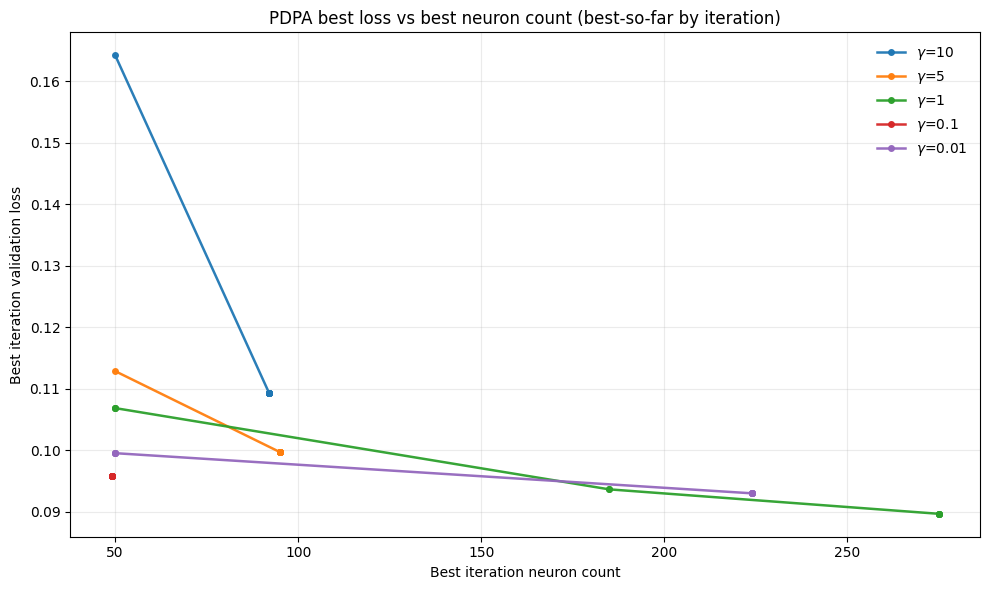

In [11]:
from scr.metric import plot_pdpa_best_loss_vs_neurons_by_iteration

# Plot raw (iteration-by-iteration) (neurons[t], val_loss[t]) pairs; exclude NaN/Inf points
plot_pdpa_best_loss_vs_neurons_by_iteration(
    model_l2,
    pdpa_key="pdpa_list_l2",
    best_so_far=True,
    marker="o",
)
# from scr.metric import plot_pdpa_best_neurons_by_iteration

# plot_pdpa_best_neurons_by_iteration(model_l2, pdpa_key="pdpa_list_l2")
# plot_pdpa_val_loss_histories_by_gamma(model_h1)